In [1]:
!pip install awscli
!pip install boto3
!pip install netCDF4
!pip install tensorflow

import time
import awscli

import numpy as np
import boto3

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
import time
import subprocess
import netCDF4 as nc
import tarfile
import os
import gc

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.dummy import DummyRegressor

def bash_string(string):
  return subprocess.run(string, shell = True, capture_output = True)

In [4]:
def knots_to_ss(knots):

  if knots == None:
    return None
  if knots == 0:
    return "MV"
  if knots <= 33:
    return "TD"
  if knots <= 63:
    return "TS"
  if knots <= 82:
    return "C1"
  if knots <= 95:
    return "C2"
  if knots <= 112:
    return "C3"
  # if knots <= 136:
  #   return "C4"
  if knots > 112:
    return "CM"
  else:
    return None

def est_windspeed(csv_name):

    try:
        return int(csv_name[-21 : -18])
    except:
        return None

def est_ss(csv_name):

  return knots_to_ss(est_windspeed(csv_name))

def random_sample(list_, sample_size, replacement):

  sample_list = []
  for _ in range(sample_size):
    rand_selection = np.random.choice(list_)
    sample_list.append(rand_selection)
    if replacement == False:
      list_.remove(rand_selection)
  return sample_list

In [5]:
# files are taken from a local repository.  The file is a CSV with 301 rows and 302 columns.  
# Columns 0 through 300 comprise the image file, and column 301 is filled with the windspeed.

bucket_list = os.listdir('/Users/nathantotz/Desktop/Hurricane_Data')
print(len(bucket_list))

7511


In [6]:
training_list = []
testing_list = []

category_list = ['TS', 'C1', 'C2', 'C3', 'CM']

for category in category_list:

  training_list += random_sample([csv_name for csv_name in bucket_list if (est_ss(csv_name) == category)], 32 * 42, replacement = False)
  testing_list += random_sample([csv_name for csv_name in bucket_list if (est_ss(csv_name) == category)], 5 * 42, replacement = False)

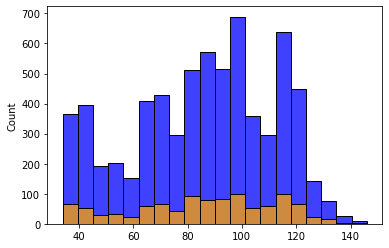

In [7]:
testing_wind = [est_windspeed(file_name) for file_name in testing_list]
training_wind = [est_windspeed(file_name) for file_name in training_list]

sns.histplot(training_wind, color = 'blue', bins = 20)
sns.histplot(testing_wind, color = 'orange', bins = 20)
plt.show()

In [8]:
# there are 7770 total images
# there are 6720 = 32 * 210 training images
# there are 1050 = 5 * 210 testing images
# so take batch_size = 210 for even division

# normalization constsants for the windspeeds and image pixel brightness
MAX_WIND = 180
MAX_PIXEL = 350

def fetch_batch(file_list, batch_size, num_of_batches):
    
    batch_number = 0
    np.random.shuffle(file_list)
    
    while True:
        
        if batch_number == num_of_batches:
            np.random.shuffle(file_list)
            batch_number = 0
        
        wind_list = []
        image_list = []
        
        for file_name in file_list[batch_number * batch_size : (batch_number + 1) * batch_size]:

            df_temp = pd.read_csv('/Users/nathantotz/Desktop/Hurricane_Data/' + file_name,
                                  index_col = 0)
            image = df_temp.iloc[:, 0 : 301]
            wind = df_temp.iloc[0, 301]
            wind_list.append(wind)
            image_list.append(image)

        X = np.array(image_list)
        X.resize(batch_size, 301, 301, 1)
        y = np.array(wind_list)

        yield (X / MAX_PIXEL, y / MAX_WIND)
        
        del(X, y, image_list, wind_list)
        gc.collect()
        batch_number += 1

In [9]:
model = models.Sequential()

model.add(layers.Conv2D(32, 
                        (3, 3), 
                        activation = 'relu',
                        input_shape = (301, 301, 1)))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64,
                 (3, 3),
                 activation = 'relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, 
                        (3, 3),
                        activation = 'relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, 
                        (3, 3),
                        activation = 'relu'))

model.add(layers.Flatten())

model.add(layers.Dense(64,
                       activation = 'relu'))

model.add(layers.Dense(1))

display(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

None

In [14]:
train_generator = fetch_batch(training_list, 210, 32)
test_generator = fetch_batch(testing_list, 210, 5)

sgd_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.018,
                                        momentum = 0.99,
                                        nesterov = True)

model.compile(optimizer = sgd_optimizer,
              loss = tf.keras.losses.MeanSquaredError(),
              metrics = ['mse'])

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = 32,
                              epochs = 20,
                              validation_data = test_generator,
                              validation_steps = 3)

Epoch 1/20
32/32 [==============================] - 683s 21s/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 2/20
32/32 [==============================] - 680s 21s/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 3/20
32/32 [==============================] - 685s 21s/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 4/20
32/32 [==============================] - 688s 22s/step - loss: 0.0075 - mse: 0.0075 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 5/20
32/32 [==============================] - 687s 22s/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 6/20
32/32 [==============================] - 688s 22s/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 7/20
32/32 [==============================] - 684s 21s/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 8/20
32/32 [==============================] - 690s 22s/step - loss: 0.

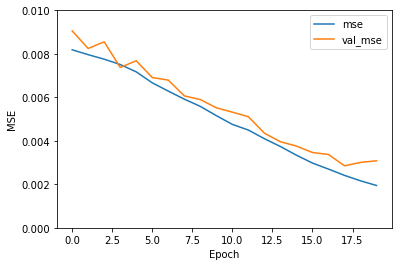

In [15]:
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label = 'val_mse')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([0, 0.0100])
plt.legend(loc='upper right')
plt.show()

In [17]:
model.save('hurricane_imagery_model.h5')

In [26]:
reloaded_model = tf.keras.models.load_model('/Users/nathantotz/Desktop/Hurricane_Imagery_Models/hurricane_imagery_model.h5')

In [31]:
df = pd.read_csv('/Users/nathantotz/Desktop/Hurricane_Imagery_Models/irma_image.csv', index_col = 0)
image = np.array(df)
image.resize(1, 301, 301, 1)
image /= 350

In [33]:
reloaded_model.predict(image)[0][0] * 180

74.36967372894287